In [1]:
# Yolo imports
from __future__ import division
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2 
import time
import argparse
import os 
import os.path as osp
import pickle as pkl
import pandas as pd
import random
from skimage import io
from matplotlib import pyplot as plt
from ConfidenceThresholdingAndNonMaximumSuppression import *
from NeuralNetwork import *
from Utilities import *

#########################################################################################################################

# Lane detection and distance estimation imports
import glob
from skimage import io, data
import matplotlib.image as mpimg
import camera_calibration
import lane_detection
import vanishing_point
#import utilities
import perspective_transform

# YOLO code to be run only once ########################################################################################

#Driver values

images = 'imgs/'
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
weights_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'

# weights_file = 'yolov3-tiny.weights'
# cfg_file = 'cfg/yolov3-tiny.cfg'

#Change cfg file and save
def SetYoloReso(reso):
    with open("cfg/yolov3.cfg", "r+") as f:
        lines = f.readlines()
        del lines[3]
        del lines[3]
        lines.insert(3, 'height = ' + str(reso) + '\n') 
        lines.insert(3, 'width = ' + str(reso) + '\n') 
        f.seek(0)
        f.truncate()
        f.writelines(lines)
        
reso = 32*11
SetYoloReso(reso)
det = 'det/'
CUDA = torch.cuda.is_available()

num_classes = 80    #For COCO
classes = load_classes("data/coco.names")

######

#Set up the neural network
print("Loading network.....")
model = Darknet(cfg_file)
model.load_weights(weights_file)
print("Network successfully loaded")

model.net_info["height"] = reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

#Set the model in evaluation mode
model.eval()

#########################################################################################################################

# Lane detection and distance estimation code to be run only once

ret, mtx, dist, rvecs, tvecs = camera_calibration.calibrate(False)

#########################################################################################################################

# YOLO prediction function
# Takes BGR image and returns: 1) image annotated with bounding boxes, 2) list of top left and bottom right
# coordinates of bounding boxes, 3) list of class numbers which correspond to class labels

def get_pred(img):
    read_dir = time.time()
    #Detection phase
    imlist = ['img']

    if not os.path.exists(det):
        os.makedirs(det)

    load_batch = time.time()
    loaded_ims = [np.array(img)]
#     loaded_ims = [cv2.undistort(np.array(img), mtx, dist, None, mtx)]
    
    #PyTorch Variables for images
    im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))

    #List containing dimensions of original images
    im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

    if CUDA:
        im_dim_list = im_dim_list.cuda()

    leftover = 0
    if (len(im_dim_list) % batch_size):
        leftover = 1

    if batch_size != 1:
        num_batches = len(imlist) // batch_size + leftover            
        im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size, len(im_batches))]))  for i in range(num_batches)]  

    write = 0
    start_det_loop = time.time()
    
    for i, batch in enumerate(im_batches):
        #load the image 
        start = time.time()
        t = time.time()  
        if CUDA:
            batch = batch.cuda()
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)
#         print("prediction: " , time.time()-t)    
        t = time.time()    
        prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)
        end = time.time()

        if type(prediction) == int:

            for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
                im_id = i*batch_size + im_num
#                 print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#                 print("{0:20s} {1:s}".format("Objects Detected:", ""))
#                 print("----------------------------------------------------------")
            continue

        prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 
    
    try:
        if not write:                      #If we have't initialised output
            output = prediction  
            write = 1
        else:
            output = torch.cat((output,prediction))

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
#             print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
#             print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
#             print("----------------------------------------------------------")

        if CUDA:
            torch.cuda.synchronize()
#         output
    except:
        #print("exception")
        return loaded_ims[0]

    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

    output[:,1:5] /= scaling_factor

    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

    class_load = time.time()
    colors = pkl.load(open("pallete", "rb"))

    draw = time.time()

    list(map(lambda x: write_img(x, loaded_ims, color = random.choice(colors), classes = classes), output))

    t = time.time()
    det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(det,x.split("/")[-1]))
    
    end = time.time()
    
#     print("SUMMARY")
###     print("----------------------------------------------------------")
###     print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
###     print()
###     print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
###     print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
###     print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
#     print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
#     print("----------------------------------------------------------")

#     t = time.time()
#     torch.cuda.empty_cache()
#     print('= Time to torch.cuda.empty_cache : ', time.time() - t)
   
    return loaded_ims[0], output[:, 1:3], output[:, 3:5], output[:, -1]

#########################################################################################################################

# Perspective transform function.
# Takes as input: 1) BGR image, 2) debug mode, 3) YOLO annotated image
# Returns: 1) Homography matrix, 2) x pixels per meter, 3) y pixels per meter
# To be called only one time one time on a base image, its outputs are then used for any image

def driver_perspective_transform(img_BGR, debug=False):
#     ud_img_BGR = cv2.undistort(img_BGR, mtx, dist, None, mtx)
    ud_img_BGR = img_BGR
    ud_img_RGB = cv2.cvtColor(ud_img_BGR, cv2.COLOR_BGR2RGB)
    if(debug):
        show_images([ud_img_RGB])
    detector = lane_detection.LaneDetector()
    lines = detector.process(ud_img_RGB, True, 0.5, 0.16, debug)
    
    vp = vanishing_point.calculate_vanishing_point(lines, ud_img_BGR, debug)
    
    H, H_inv, warped = perspective_transform.perspective_transform(vp, ud_img_BGR, debug)
    
    x_pixels_per_meter , y_pixels_per_meter, left_low, left_high, right_low, right_high = \
                    perspective_transform.get_ratio(H, H_inv, warped, mtx, debug)

    return H, x_pixels_per_meter, y_pixels_per_meter

#########################################################################################################################

# Distance estimation function
# Takes as input: 1) Query pixel, 2) Bottom center coordinates of screen, 3) homography matrix,
# 4) x pixels per meter, 5) y pixels per meter
# Returns distance to the query pixel
def get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter):
    return perspective_transform.get_distance(query_pnt, center, H, x_pixels_per_meter, y_pixels_per_meter)

#######################################################################################################################

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading network.....
Network successfully loaded


In [2]:
# Annotates image with lanes or prints on image that lane departure is detected
# Inputs: 1) image, 2) resolution of image / 1200x500 resolution
# Outputs: 2) Annotated image

def get_lane_image(img, ratio, debug=False):

    base_left_m, base_left_c, base_right_m, base_right_c = -0.32785089597153977, 446.0614062879984*ratio,\
                                                            0.2911316010810115, 79.62376483613377*ratio
    max_m_diff, max_c_diff = 0.13, 50

    test_img = np.array(img)
    width, height = test_img.shape[1], test_img.shape[0]

    detector = lane_detection.LaneDetector()
    lines = detector.process(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB), True, 0.4, 0.5, debug)

    left_lane_lines, right_lane_lines = lane_detection.get_lane_lines(lines, base_left_m, base_left_c, base_right_m,
                                                                      base_right_c, max_m_diff, max_c_diff)
    if(len(left_lane_lines)==0 or len(right_lane_lines)==0):
        cv2.putText(test_img,
            "Not between 2 lanes",
            (int(width/2-150), 50), 
            font, 
            fontScale,
            fontColor,
            lineType)
    else:
        left_lane_line, right_lane_line = get_lines_mean(left_lane_lines), get_lines_mean(right_lane_lines)
        low_y, high_y = height-1, int(height * 0.6)
        left_low, left_high = (int((low_y-left_lane_line[1])/left_lane_line[0]), low_y),\
                              (int((high_y-left_lane_line[1])/left_lane_line[0]), high_y)
        right_low, right_high = (int((low_y-right_lane_line[1])/right_lane_line[0]), low_y),\
                              (int((high_y-right_lane_line[1])/right_lane_line[0]), high_y)
        cv2.line(test_img, tuple(left_low), tuple(left_high),(0,0,255),5)
        cv2.line(test_img, tuple(right_low), tuple(right_high),(0,0,255),5)
    
    return test_img

In [21]:
##Calculating relative velocities and accelerations from distances values, and checking for emergency brake

import math
import threading
import time

dist = 0
rel_vel = 0
rel_acc = 0
t = time.time()

def scale(val, src, dst):
    return ((val - src[0]) / (src[1]-src[0])) * (dst[1]-dst[0]) + dst[0]

# braking = False
def Brake2Secs():
#     global braking
#     print('a')
#     if(not braking):
#         print('b')
#     braking = True
    BADAS_fns.StartFullBrake()
    time.sleep(3)
    BADAS_fns.StopBrake()
#     braking = False

def BrakeDecide(new_dist):
    global dist
    global rel_vel
    global rel_acc
    global t
    
#     test using actual distance exctract from sim
#     packet = BADAS_fns.client.getAdasPacket()  
#     new_dist = packet[1]

    rel_vel_tmp = ( dist - new_dist ) / (time.time() - t)
    rel_acc = ( rel_vel - rel_vel_tmp) / (time.time() - t)
    
#     test w/o quadtratic eq
#     rel_acc = 0

    rel_vel = rel_vel_tmp
    dist = new_dist
    
#     print('distance = ' , dist )
#     print('rel_vel = ' , rel_vel )
#     print('rel_acc = ' , rel_acc )
#     print('rel time = ' , time.time() - t )
    t = time.time()
    
#     if(new_dist > 60):
#         print('Brake = 0')
#         return False
    
    if VisionEmergencyCheck(rel_acc,rel_vel,dist):
        print('Brake = 1')
        threading.Thread(target=Brake2Secs).start()
        return True
    else:
        print('Brake = 0')
        return False
    
def ThresholdCheck(T):
    print('T for collision: ', T)
    if(T <= 0.5 and T > 0):
#         if( T < 1 and T > 0.2 ):
#             ManueverRight()
        return True
    return False

# a: 0.5 * acc
# b: vel
# c: -distance
def VisionEmergencyCheck(acc, vel, dist):
    if( vel < 0.001):
        return False
    
    if( acc == 0 ):
        return ThresholdCheck(dist/vel)
    else:
        a = 0.5 * acc
        b = vel
        c = -dist
        
        d = (b**2) - (4*a*c)
        if(d<0):
#             print('No collision (d<0)')
            return False
        
        T = (-b+math.sqrt(d))/(2*a)
        return ThresholdCheck(T)

# while True:
#     time.sleep(0.1)
#     BrakeDecide(0)
# BADAS_fns.StopBrake()

##################################################################################################################################################################
##Change Airsim
from shutil import copy2
AirSimDocPath = os.path.expanduser('~/Documents') + '/AirSim'
highres = False

def SetSimImgRes(resoW,resoH):
    AirSimDocPath = os.path.expanduser('~/Documents') + '/AirSim/settings.json'
    with open(AirSimDocPath , "r+") as f:
        lines = f.readlines()
        del lines[10]
        del lines[10]
        lines.insert(10, '"Height": ' + str(resoH) + '\n') 
        lines.insert(10, '"Width": ' + str(resoW) + ',\n') 
        f.seek(0)
        f.truncate()
        f.writelines(lines)
        
def SetSimImgRes500x208():
    global highres
    highres = False
    SetSimImgRes(500,208)
def SetSimImgRes1200x500():
    global highres
    highres = True
    SetSimImgRes(1200,500)

#Sim MUST BE RESTARTED TO TAKE EFFECT
SetSimImgRes500x208()
# SetSimImgRes1200x500()

In [22]:
# Sim Real-time distance detection and showing output using CV2
# import numpy

##################################################################################################################################################################

# Importing Airsim and connecting
# Uses local airsim package (DO NOT pip install, UNINSTALL IF INSTALLED ALREADY: "pip uninstall airsim")
from pathlib import Path
import sys
import os
from ctypes import *
sys.path.append(str(Path().resolve().parent.parent).replace('\\','/') + '/AirSimClient')
os.environ['PATH'] = str(Path().resolve().parent.parent).replace('\\','/') + '/AirSimClient' + os.pathsep + os.environ['PATH']
d = CDLL('SDL2.dll')
import BADAS_fns
BADAS_fns.Find_BADAS_Client()
time.sleep(0.5)
BADAS_fns.client.confirmConnection()

def GetSimImg():
    responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
    response = responses[0]
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
    img = img1d.reshape(response.height, response.width, 4)  
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


##################################################################################################################################################################

# Preparing text style that will be used in writing distances
font                   = cv2.FONT_HERSHEY_SIMPLEX
pos = (0,0)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

img = cv2.imread('imgs/noshade1200x500.JPG')
H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, False)

#Calculate distance accuracy 
dist_lst1 = []

while True:
    # Press "q" to quit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

    t3 = time.time()
    t1 = t3
    img = GetSimImg()
    print('T Sim image extract: ' , time.time() - t1)
    
    # Image bottom center coordinates
    center = [img.shape[1]//2, img.shape[0]-1]
    
    try:
        img = get_lane_image(img, float(img.shape[0])/500)
        # Getting predictions from yolo
        t1 = time.time()
        pred, top_left, bottom_right, labels = get_pred(img)
        print('T Yolo: ' , time.time() - t1)
    except:
        print('YException ')
        cv2.imshow("", img)
        continue
        
    t1 = time.time()
    # Looping on every detected object
    for i in range(len(labels)):
        # Object label
        label = classes[int(labels[i])]

        if(label != "car"):
            continue

        # Top left x,y
        tlx, tly = int(top_left[i,0]), int(top_left[i,1])

        # Bottom right x,y
        brx, bry = int(bottom_right[i,0]), int(bottom_right[i,1])

        # Bottom center coordinates of bounding box
        cx, cy = (tlx + brx)//2, bry

        #print(str(cx) + "," + str(cy) + " | " + str(center[0]) + "," + str(center[1]))

        # Distance to car
#         float_dist = get_distance([cx, cy], center, H, x_pixels_per_meter, y_pixels_per_meter)
        float_dist = get_distance(scale_pixel([cx, cy], img.shape), scale_pixel(center, img.shape), H, x_pixels_per_meter, y_pixels_per_meter)
    
        #Mapping distance
#         float_dist = scale(float_dist, (3.82, 71.17) , (2.75, 22.9))
        
        EmergencyBool = BrakeDecide(float_dist)
        
        # Extract distance from sim #########################
        try:
            packet = BADAS_fns.client.getAdasPacket()  
            actual_dist = packet[1]
            dist_lst1.append( abs(actual_dist - float_dist) )
        except:
            pass
        ############################################################

        distance = str(round_float(float_dist))+"m"
        
        if(EmergencyBool):
            # Annotate yolo image with distance to car
            cv2.putText(pred,
                "EMERGENCY",
                (cx-60, cy-60), 
                font, 
                fontScale,
                fontColor,
                lineType)
       # Annotate yolo image with distance to car
        cv2.putText(pred,
        distance,
        (cx-60, cy+30), 
        font, 
        fontScale,
        fontColor,
        lineType)

        print('T Get distance: ' , time.time() - t1)
        
    #print(x_pixels_per_meter)
    #print(y_pixels_per_meter)
    print('T Total: ' , time.time() - t3)
    cv2.imshow("", pred)
    print('\n')
    #show_images([cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)])
print('num: ' , len(dist_lst1))
print("dist mean absolute error: ", sum(dist_lst1) / len(dist_lst1) )

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

pxls/mtr: 33.35520666666667,45.70352015283409
T Sim image extract:  0.21187043190002441
T Yolo:  0.12592172622680664
T Total:  0.3487865924835205


T Sim image extract:  0.018987417221069336
T Yolo:  0.11892485618591309
T Total:  0.14591002464294434


T Sim image extract:  0.017987728118896484
T Yolo:  0.1169271469116211
T Total:  0.14391040802001953


T Sim image extract:  0.008994817733764648
YException 
T Sim image extract:  0.00899505615234375
T Yolo:  0.11792683601379395
T Total:  0.13391757011413574


T Sim image extract:  0.015990495681762695
T Yolo:  0.11792683601379395
T Total:  0.14191246032714844


T Sim image extract:  0.008996009826660156
T Yolo:  0.11193370819091797
T Total:  0.12792515754699707


T Sim image extract:  0.011992216110229492
T Yolo:  0.11592769622802734
T Total:  0.13491582870483398


T Sim image extract:  0.008995294570922852
YException 
T Sim image extract:  0.00899505615234375
YException 
T

T Total:  0.1469113826751709


T Sim image extract:  0.00799560546875
T Yolo:  0.11893081665039062
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.14291620254516602


T Sim image extract:  0.008994579315185547
T Yolo:  0.1189274787902832
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.14491009712219238


T Sim image extract:  0.007995843887329102
T Yolo:  0.12092876434326172
Brake = 0
T Get distance:  0.003996849060058594
T Total:  0.14391469955444336


T Sim image extract:  0.008995771408081055
T Yolo:  0.11992740631103516
T for collision:  0.6707219516683448
Brake = 0
T Get distance:  0.005604743957519531
T Total:  0.14851737022399902


T Sim image extract:  0.008996725082397461
T Yolo:  0.11792755126953125
Brake = 0
T Get distance:  0.0029973983764648438
T Total:  0.1429119110107422


T Sim image extract:  0.008995771408081055
T Yolo:  0.11392879486083984
Brake = 0
T Get distance:  0.0059969425201416016
T Total:  0.1409139633178711


T Sim image extract:  0.

T Get distance:  0.005997180938720703
T Total:  0.14591050148010254


T Sim image extract:  0.00799703598022461
T Yolo:  0.11647439002990723
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.14046216011047363


T Sim image extract:  0.008994817733764648
T Yolo:  0.12392282485961914
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.14990758895874023


T Sim image extract:  0.007996320724487305
T Yolo:  0.1169276237487793
Brake = 0
T Get distance:  0.003996610641479492
T Total:  0.14391183853149414


T Sim image extract:  0.008995294570922852
T Yolo:  0.11093020439147949
Brake = 0
T Get distance:  0.0049970149993896484
T Total:  0.1389141082763672


T Sim image extract:  0.008994579315185547
T Yolo:  0.1169271469116211
Brake = 0
T Get distance:  0.0029985904693603516
T Total:  0.14391207695007324


T Sim image extract:  0.00899505615234375
T Yolo:  0.11392807960510254
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.1429131031036377


T Sim image extract: 

T Sim image extract:  0.008995771408081055
YException 
T Sim image extract:  0.007994651794433594
YException 
T Sim image extract:  0.008996725082397461
T Yolo:  0.11392951011657715
T Total:  0.13191962242126465


T Sim image extract:  0.007995128631591797
T Yolo:  0.11793160438537598
Brake = 0
T Get distance:  0.003997325897216797
T Total:  0.14091920852661133


T Sim image extract:  0.008994102478027344
T Yolo:  0.11365032196044922
T Total:  0.13064122200012207


T Sim image extract:  0.009996652603149414
T Yolo:  0.1109321117401123
Brake = 0
T Get distance:  0.003996849060058594
T Total:  0.1389153003692627


T Sim image extract:  0.007996559143066406
T Yolo:  0.11592793464660645
T for collision:  2.481060781676405
Brake = 0
T Get distance:  0.006994485855102539
T Total:  0.14591097831726074


T Sim image extract:  0.007995843887329102
T Yolo:  0.1129302978515625
T Total:  0.1329195499420166


T Sim image extract:  0.009993791580200195
T Yolo:  0.1169283390045166
T Total:  0.1349160

T Sim image extract:  0.008995294570922852
T Yolo:  0.1209266185760498
Brake = 0
T Get distance:  0.0039975643157958984
T Total:  0.14772796630859375


T Sim image extract:  0.007994890213012695
T Yolo:  0.11792778968811035
T for collision:  1.1723095422891878
Brake = 0
T Get distance:  0.006995677947998047
T Total:  0.14890789985656738


T Sim image extract:  0.011991262435913086
T Yolo:  0.11792659759521484
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.14391064643859863


T Sim image extract:  0.007995128631591797
T Yolo:  0.11992549896240234
T for collision:  0.18711365945498337
Brake = 1
T Get distance:  0.01099252700805664
T Total:  0.15190768241882324


T Sim image extract:  0.008996248245239258
T Yolo:  0.118927001953125
T for collision:  0.07511740860296966
Brake = 1
T Get distance:  0.005995750427246094
T Total:  0.1469106674194336


T Sim image extract:  0.00899505615234375
YException 
T Sim image extract:  0.009996652603149414
YException 
T Sim image extract:  0

T Total:  0.1529064178466797


T Sim image extract:  0.008996009826660156
T Yolo:  0.12392377853393555
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.1489088535308838


T Sim image extract:  0.008995294570922852
T Yolo:  0.11792731285095215
Brake = 0
T Get distance:  0.003996610641479492
T Total:  0.1429133415222168


T Sim image extract:  0.008994340896606445
T Yolo:  0.11812996864318848
Brake = 0
T Get distance:  0.002996206283569336
T Total:  0.14411401748657227


T Sim image extract:  0.008995532989501953
T Yolo:  0.11792731285095215
T Total:  0.1369156837463379


T Sim image extract:  0.008993864059448242
T Yolo:  0.1149284839630127
Brake = 0
T Get distance:  0.0029878616333007812
T Total:  0.14350342750549316


T Sim image extract:  0.008995532989501953
YException 
T Sim image extract:  0.008996248245239258
T Yolo:  0.10993123054504395
Brake = 0
T Get distance:  0.003997325897216797
T Total:  0.13791608810424805


T Sim image extract:  0.008996009826660156
T Yolo:  

T Yolo:  0.1249232292175293
T for collision:  0.7699250820326671
Brake = 0
T Get distance:  0.005995988845825195
T Total:  0.15190672874450684


T Sim image extract:  0.008995294570922852
T Yolo:  0.11792659759521484
Brake = 0
T Get distance:  0.003997325897216797
T Total:  0.1429121494293213


T Sim image extract:  0.008994579315185547
T Yolo:  0.11792778968811035
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.1429121494293213


T Sim image extract:  0.008995532989501953
T Yolo:  0.12592196464538574
Brake = 0
T Get distance:  0.0039975643157958984
T Total:  0.15590429306030273


T Sim image extract:  0.009993553161621094
T Yolo:  0.1309196949005127
Brake = 0
T Get distance:  0.004997968673706055
T Total:  0.15790247917175293


T Sim image extract:  0.008995532989501953
T Yolo:  0.12792038917541504
Brake = 0
T Get distance:  0.005997180938720703
T Total:  0.15690302848815918


T Sim image extract:  0.008994817733764648
T Yolo:  0.1249232292175293
Brake = 0
T Get distance: 

T Sim image extract:  0.00899505615234375
T Yolo:  0.12632012367248535
T Total:  0.1473088264465332


T Sim image extract:  0.008992433547973633
T Yolo:  0.12492251396179199
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.15090537071228027


T Sim image extract:  0.008995532989501953
T Yolo:  0.11992669105529785
Brake = 0
T Get distance:  0.002997159957885742
T Total:  0.14591026306152344


T Sim image extract:  0.008996248245239258
T Yolo:  0.11867094039916992
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.1446547508239746


T Sim image extract:  0.008995532989501953
T Yolo:  0.11792778968811035
Brake = 0
T Get distance:  0.0029973983764648438
T Total:  0.14391183853149414


T Sim image extract:  0.008996248245239258
T Yolo:  0.1189272403717041
Brake = 0
T Get distance:  0.0029985904693603516
T Total:  0.14391207695007324


T Sim image extract:  0.008996009826660156
T Yolo:  0.13292193412780762
Brake = 0
T Get distance:  0.003997087478637695
T Total:  0.16090

T Sim image extract:  0.008995771408081055
T Yolo:  0.11792778968811035
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.14391160011291504


T Sim image extract:  0.008995771408081055
T Yolo:  0.1169281005859375
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.14391183853149414


T Sim image extract:  0.008995532989501953
T Yolo:  0.1189267635345459
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.1449108123779297


T Sim image extract:  0.008995532989501953
T Yolo:  0.11592864990234375
T Total:  0.13591718673706055


T Sim image extract:  0.008994817733764648
T Yolo:  0.12192320823669434
Brake = 0
T Get distance:  0.005995988845825195
T Total:  0.14790940284729004


T Sim image extract:  0.008993864059448242
T Yolo:  0.12192702293395996
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.14871644973754883


T Sim image extract:  0.00899505615234375
T Yolo:  0.1209251880645752
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.146909

T Get distance:  0.003997325897216797
T Total:  0.1389153003692627


T Sim image extract:  0.008995532989501953
T Yolo:  0.11592769622802734
Brake = 0
T Get distance:  0.0029985904693603516
T Total:  0.1369163990020752


T Sim image extract:  0.013991117477416992
T Yolo:  0.1189260482788086
Brake = 0
T Get distance:  0.003998756408691406
T Total:  0.1509075164794922


T Sim image extract:  0.008996963500976562
T Yolo:  0.11592817306518555
Brake = 0
T Get distance:  0.003997802734375
T Total:  0.1389150619506836


T Sim image extract:  0.009994029998779297
T Yolo:  0.1169271469116211
Brake = 0
T Get distance:  0.003997087478637695
T Total:  0.14790964126586914


T Sim image extract:  0.008994579315185547
T Yolo:  0.11392807960510254
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.14191341400146484


T Sim image extract:  0.00899505615234375
T Yolo:  0.11392879486083984
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.1409144401550293


T Sim image extract:  0.008

T Sim image extract:  0.008996009826660156
T Yolo:  0.11766290664672852
Brake = 0
T Get distance:  0.0039980411529541016
T Total:  0.14364933967590332


T Sim image extract:  0.008994579315185547
T Yolo:  0.10793328285217285
Brake = 0
T Get distance:  0.003998279571533203
T Total:  0.1329183578491211


T Sim image extract:  0.008994817733764648
T Yolo:  0.1109311580657959
Brake = 0
T Get distance:  0.002996683120727539
T Total:  0.13791465759277344


T Sim image extract:  0.008994817733764648
T Yolo:  0.11193037033081055
Brake = 0
T Get distance:  0.004997730255126953
T Total:  0.1389141082763672


T Sim image extract:  0.008996009826660156
T Yolo:  0.11592745780944824
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.14391207695007324


T Sim image extract:  0.008994579315185547
T Yolo:  0.11492800712585449
Brake = 0
T Get distance:  0.004996538162231445
T Total:  0.14191341400146484


T Sim image extract:  0.008994340896606445
T Yolo:  0.11592745780944824
Brake = 0
T Get di

T Total:  0.13791632652282715


T Sim image extract:  0.008995294570922852
T Yolo:  0.11892557144165039
Brake = 0
T Get distance:  0.003996610641479492
T Total:  0.14391279220581055


T Sim image extract:  0.007994651794433594
T Yolo:  0.1169271469116211
Brake = 0
T Get distance:  0.0029985904693603516
T Total:  0.13991475105285645


T Sim image extract:  0.008994579315185547
T Yolo:  0.11500811576843262
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.13799500465393066


T Sim image extract:  0.009993791580200195
T Yolo:  0.11492729187011719
Brake = 0
T Get distance:  0.0029985904693603516
T Total:  0.14191269874572754


T Sim image extract:  0.007993936538696289
T Yolo:  0.08849763870239258
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.111480712890625


T Sim image extract:  0.00799417495727539
T Yolo:  0.08894634246826172
Brake = 0
T Get distance:  0.002998828887939453
T Total:  0.1109318733215332


T Sim image extract:  0.008993148803710938
T Yolo:  0.0889



T Sim image extract:  0.008996009826660156
T Yolo:  0.08894872665405273
Brake = 0
T Get distance:  0.003998517990112305
T Total:  0.11193513870239258


T Sim image extract:  0.008995771408081055
T Yolo:  0.11187982559204102
Brake = 0
T Get distance:  0.003997802734375
T Total:  0.14086365699768066


T Sim image extract:  0.008994579315185547
T Yolo:  0.11393260955810547
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.13791871070861816


T Sim image extract:  0.009994268417358398
T Yolo:  0.11893010139465332
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.1429154872894287


T Sim image extract:  0.008994817733764648
T Yolo:  0.11887955665588379
Brake = 0
T Get distance:  0.0039975643157958984
T Total:  0.14386653900146484


T Sim image extract:  0.00899505615234375
T Yolo:  0.1194310188293457
Brake = 0
T Get distance:  0.004997730255126953
T Total:  0.14641571044921875


T Sim image extract:  0.007994651794433594
T Yolo:  0.12071347236633301
Brake = 0
T Get dist

YException 
T Sim image extract:  0.007996797561645508
YException 
T Sim image extract:  0.00799560546875
T Yolo:  0.1189260482788086
T Total:  0.1409139633178711


T Sim image extract:  0.00799560546875
T Yolo:  0.1109306812286377
T Total:  0.1309196949005127


T Sim image extract:  0.016990184783935547
YException 
T Sim image extract:  0.008996248245239258
YException 
T Sim image extract:  0.008995294570922852
T Yolo:  0.11792755126953125
T Total:  0.14191317558288574


T Sim image extract:  0.008995294570922852
T Yolo:  0.12392282485961914
T Total:  0.1449122428894043


T Sim image extract:  0.008994340896606445
T Yolo:  0.1249229907989502
T Total:  0.14591002464294434


T Sim image extract:  0.008994817733764648
YException 
T Sim image extract:  0.013000726699829102
T Yolo:  0.11392927169799805
T Total:  0.1349172592163086


T Sim image extract:  0.008996248245239258
YException 
T Sim image extract:  0.015990495681762695
YException 
T Sim image extract:  0.008995294570922852
T Yolo

T Yolo:  0.1209261417388916
Brake = 0
T Get distance:  0.0029976367950439453
T Total:  0.1429126262664795


T Sim image extract:  0.00799703598022461
T Yolo:  0.11792612075805664
Brake = 0
T Get distance:  0.003996849060058594
T Total:  0.1449110507965088


T Sim image extract:  0.008994817733764648
T Yolo:  0.11193037033081055
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.1369168758392334


T Sim image extract:  0.007994890213012695
T Yolo:  0.11692667007446289
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.1429126262664795


T Sim image extract:  0.008994340896606445
T Yolo:  0.11792659759521484
Brake = 0
T Get distance:  0.003997325897216797
T Total:  0.1429131031036377


T Sim image extract:  0.008994817733764648
T Yolo:  0.11392903327941895
Brake = 0
T Get distance:  0.002997875213623047
T Total:  0.1369152069091797


T Sim image extract:  0.010992765426635742
T Yolo:  0.1129300594329834
Brake = 0
T Get distance:  0.003997802734375
T Total:  0.138914108276

T Get distance:  0.002997875213623047
T Total:  0.148911714553833


T Sim image extract:  0.008996725082397461
T Yolo:  0.11093497276306152
T Total:  0.12892627716064453


T Sim image extract:  0.011991739273071289
T Yolo:  0.11693096160888672
T Total:  0.13791680335998535


T Sim image extract:  0.008996963500976562
T Yolo:  0.10893034934997559
Brake = 0
T Get distance:  0.005997657775878906
T Total:  0.1349179744720459


T Sim image extract:  0.007994651794433594
T Yolo:  0.11343526840209961
Brake = 0
T Get distance:  0.0059967041015625
T Total:  0.14263367652893066


T Sim image extract:  0.007995367050170898
T Yolo:  0.11443901062011719
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.14142537117004395


T Sim image extract:  0.008994340896606445
T Yolo:  0.1129298210144043
Brake = 0
T Get distance:  0.00299835205078125
T Total:  0.13491606712341309


T Sim image extract:  0.015990257263183594
T Yolo:  0.11492776870727539
Brake = 0
T Get distance:  0.0039975643157958984

T Total:  0.13591694831848145


T Sim image extract:  0.011993646621704102
T Yolo:  0.11692667007446289
T Total:  0.1369156837463379


T Sim image extract:  0.008995532989501953
T Yolo:  0.11193060874938965
T for collision:  0.6721739017821792
Brake = 0
T Get distance:  0.007994651794433594
T Total:  0.14091253280639648


T Sim image extract:  0.008996009826660156
T Yolo:  0.1109316349029541
T Total:  0.1289207935333252


T Sim image extract:  0.01099252700805664
T Yolo:  0.11592698097229004
T for collision:  1.3002281633168344
Brake = 0
T Get distance:  0.00699615478515625
T Total:  0.14790940284729004


T Sim image extract:  0.008995532989501953
T Yolo:  0.11292910575866699
T Total:  0.13191843032836914


T Sim image extract:  0.00899648666381836
T Yolo:  0.1109316349029541
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.13791537284851074


T Sim image extract:  0.008994579315185547
T Yolo:  0.1109304428100586
Brake = 0
T Get distance:  0.0039975643157958984
T Total:  0.

T Yolo:  0.1189262866973877
Brake = 0
T Get distance:  0.003997087478637695
T Total:  0.14391207695007324


T Sim image extract:  0.008996009826660156
T Yolo:  0.1249229907989502
Brake = 0
T Get distance:  0.0029981136322021484
T Total:  0.14890789985656738


T Sim image extract:  0.008996725082397461
T Yolo:  0.11592888832092285
Brake = 0
T Get distance:  0.0039975643157958984
T Total:  0.1409144401550293


T Sim image extract:  0.008993864059448242
T Yolo:  0.11792802810668945
Brake = 0
T Get distance:  0.0029990673065185547
T Total:  0.14291048049926758


T Sim image extract:  0.008995294570922852
T Yolo:  0.11992692947387695
Brake = 0
T Get distance:  0.003997325897216797
T Total:  0.14590930938720703


T Sim image extract:  0.007996320724487305
T Yolo:  0.11193060874938965
T Total:  0.1349174976348877


T Sim image extract:  0.007993936538696289
YException 
T Sim image extract:  0.007995128631591797
T Yolo:  0.1109316349029541
T Total:  0.13191938400268555


T Sim image extract:  

T Sim image extract:  0.008996248245239258
T Yolo:  0.1209256649017334
T for collision:  0.3297657605058279
Brake = 1
T Get distance:  0.005996227264404297
T Total:  0.148909330368042


T Sim image extract:  0.007995843887329102
T Yolo:  0.12292313575744629
T for collision:  0.19406843513457192
Brake = 1
T Get distance:  0.006995677947998047
T Total:  0.14990830421447754


T Sim image extract:  0.009995222091674805
T Yolo:  0.1269221305847168
T Total:  0.1509077548980713


T Sim image extract:  0.008994817733764648
YException 
T Sim image extract:  0.00899505615234375
YException 
T Sim image extract:  0.007995128631591797
YException 
T Sim image extract:  0.010991811752319336
YException 
T Sim image extract:  0.013991832733154297
T Yolo:  0.12592267990112305
T Total:  0.15090703964233398


T Sim image extract:  0.008995294570922852
T Yolo:  0.12392234802246094
T Total:  0.1469099521636963


T Sim image extract:  0.007996082305908203
T Yolo:  0.11892557144165039
T for collision:  0.3944

Exception in thread Thread-196:
Traceback (most recent call last):
  File "c:\users\hesha\desktop\py37\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "c:\users\hesha\desktop\py37\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-21-d7d4edb2a7b8>", line 24, in Brake2Secs
    BADAS_fns.StopBrake()
  File "C:/Users/hesha/Desktop/Brain-ADAS/AirSimClient\BADAS_fns.py", line 135, in StopBrake
    client.setBrakeInput(0)
  File "C:/Users/hesha/Desktop/Brain-ADAS/AirSimClient\airsim\client.py", line 593, in setBrakeInput
    self.client.call('setBrakeInput', brake_inp , vehicle_name)
  File "c:\users\hesha\desktop\py37\lib\site-packages\msgpackrpc\session.py", line 41, in call
    return self.send_request(method, args).get()
  File "c:\users\hesha\desktop\py37\lib\site-packages\msgpackrpc\future.py", line 25, in get
    self.join()
  File "c:\users\hesha\desktop\py37\lib\site-packages\msgpackrpc\future.py", line 22,

T Sim image extract:  0.01499176025390625
T Yolo:  0.12392449378967285
Brake = 0
T Get distance:  0.003997087478637695
T Total:  0.1509077548980713


T Sim image extract:  0.00799560546875
T Yolo:  0.12092423439025879
Brake = 0
T Get distance:  0.003998279571533203
T Total:  0.14191246032714844


num:  788
dist mean absolute error:  5.200129475004102


In [ ]:
# Reading image
img = cv2.imread('imgs/noshade1200x500.JPG')

print(img.shape)

# Image bottom center coordinates
center = [img.shape[1]//2, img.shape[0]-1]

# Preparing text style that will be used in writing distances
font                   = cv2.FONT_HERSHEY_SIMPLEX
pos = (0,0)
fontScale              = 1
fontColor              = (0,0,0)
lineType               = 2

# Getting predictions from yolo
pred, top_left, bottom_right, labels = get_pred(img)
    
# Perform perspective transform and annotate yolo image
H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, True)

# Looping on every detected object
for i in range(len(labels)):
    
    # Object label
    label = classes[int(labels[i])]
    
    if(label != "car"):
        continue
        
    # Top left x,y
    tlx, tly = int(top_left[i,0]), int(top_left[i,1])
    
    # Bottom right x,y
    brx, bry = int(bottom_right[i,0]), int(bottom_right[i,1])
        
    # Bottom center coordinates of bounding box
    cx, cy = (tlx + brx)//2, bry
    
    print(str(cx) + "," + str(cy) + " | " + str(center[0]) + "," + str(center[1]))
    
    # Distance to car
    float_dist = get_distance([cx, cy], center, H, x_pixels_per_meter, y_pixels_per_meter)

    distance = str(round_float(float_dist))+"m"
    
    # Annotate yolo image with distance to car
    cv2.putText(pred,
        distance,
        (cx-60, cy+30), 
        font, 
        fontScale,
        fontColor,
        lineType)

print(x_pixels_per_meter)
print(y_pixels_per_meter)
    
show_images([cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)])

In [ ]:
test_img1 = cv2.imread('imgs/1202x498.jpg')
out_img1 = get_lane_image(test_img1, 1)
show_images([cv2.cvtColor(out_img1, cv2.COLOR_BGR2RGB)])

test_img2 = cv2.imread('imgs/noshade500x208.jpg')
out_img2 = get_lane_image(test_img2, 500/1200.0)
show_images([cv2.cvtColor(out_img2, cv2.COLOR_BGR2RGB)])


In [ ]:
cnt = 0
directory = os.fsencode("images1")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"):
        test_img = cv2.imread("images1/"+filename)
        out_img = get_lane_image(test_img, float(test_img.shape[0])/500)
        cv2.imwrite("out_images1/out"+str(cnt)+".jpg", out_img)
        cnt += 1

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#BADAS v2.6+
def SteerByAngle(angle, direction):
    
    FirstVec = BADAS_fns.client.getSuvFwdVec() #Get first forward vector
    
    car_controls = BADAS_fns.airsim.CarControls()
    
    car_controls.throttle = 0 # Change later, need to meet certain velocity depending on manuever equation
    
    if(direction == 'right'):
        car_controls.steering = 1
    elif(direction == 'left'):
        car_controls.steering = -1
        
    #Start steering    
    BADAS_fns.client.enableApiControl(True)  
    BADAS_fns.client.setCarControls(car_controls)
    
    #Keep steering until required angle is met
    while (True):
        SecVec = BADAS_fns.client.getSuvFwdVec()
        radians = angle_between( (FirstVec['X'], FirstVec['Y']), (SecVec['X'], SecVec['Y'])) #Get angle betwen first and second forward vectors
        
        if(math.degrees(radians) >= angle): #Stop steering if required angle is met
            break
        
        if(BADAS_fns.client.getCarState().speed < 1): #Stop steering in case of errors
            break
            
        time.sleep(0.01)
        
    BADAS_fns.client.enableApiControl(False) # Return driver full controls

def ManueverRight():
    SteerByAngle(20,'right')
    time.sleep(0.1)   
    SteerByAngle(20,'left')

In [ ]:
try:
    while True:
        #starttime = time.time()
        t = time.time()
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        img1d = np.frombuffer(response.image_data_uint8, dtype=np.uint8) 
        img_rgba = img1d.reshape(response.height, response.width, 4)  
        img_rgba = cv2.resize(img_rgba, dsize=(256, 128), interpolation=cv2.INTER_NEAREST) #####################RESIZING FOR FAST PREDICTION
        print('= T Extract sim image: ' , time.time()-t)

        t = time.time()
        detected = get_pred(img_rgba)
        print('= T Detecting: ' , time.time()-t)
        
        cv2.imshow("img", detected)
        #print('=== TOTAL TIME ' , time.time()-starttime , ' ===\n')
        
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
except:
    cv2.destroyAllWindows()

In [ ]:
import time
x = 100
while True:
    x = x -1
    if x < 0:
        break
    t = time.time()
    png_image = client.simGetImage("1", airsim.ImageType.Scene)
    print('time: ' , time.time()-t)

In [ ]:
BADAS_fns.Find_BADAS_Client()
time.sleep(0.5)
BADAS_fns.client.confirmConnection()

In [ ]:
responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
response = responses[0]
img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
img = img1d.reshape(response.height, response.width, 4)  
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [ ]:
#Print average of time to detect img and predict
timeout = time.time() + 3 #5 secs

lst = [] 
lst2 = [] 

while True:
    if time.time() > timeout:
        break
    start = time.time()
    responses = BADAS_fns.client.simGetImages([ BADAS_fns.airsim.ImageRequest("0", BADAS_fns.airsim.ImageType.Scene, False, False) ])
    response = responses[0]
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
    img = img1d.reshape(response.height, response.width, 4)  
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    print("T SimGetImg =", time.time() - start ) 
    lst2.append(time.time() - start)
    
    start = time.time()
    detected = get_pred(img)
    print("T Yolo =", time.time() - start ) 
    lst.append(time.time() - start)
        
print("AverageGetImage =", sum(lst2) / len(lst2) ) 
print("AverageYolo =", sum(lst) / len(lst) ) 

In [ ]:
#40fps fullscreen quality3 AverageAll = 0.105, AverageGetImage = 0.0021

#over lan 35fps fullscreen quality3
#AverageGetImage = 0.019696117627738725
#AverageAll = 0.09919774414289116

In [ ]:
import time
timeout = time.time() + 5 #5 secs

while True:
    if time.time() > timeout:
        break
    x = 0
    start = time.time()
    while True:
        responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
        response = responses[0]
        #detected = get_pred((np.frombuffer(response.image_data_uint8, dtype=np.uint8) ).reshape(response.height, response.width, 4))
        if(time.time() - start > 1):
            break
        x += 1

    print(x)

In [ ]:
#SHOW ONE IMAEG
png_image = BADAS_fns.client.simGetImage("0", BADAS_fns.airsim.ImageType.Scene)
Image.open(io.BytesIO(png_image)).show()

In [ ]:
import mss
import mss.tools
import time
from PIL import Image

while True:
    
    
    with mss.mss() as sct:
        for num, monitor in enumerate(sct.monitors[1:], 1):
            # Get raw pixels from the screen
            sct_img = sct.grab(monitor)
            # Create the Image
            img = Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")

        # Grab the data
        t = time.time()
        sct_img = sct.grab(monitor)
        print(time.time() - t)
        #sct_img.
        #print(type(sct_img))
        # Save to the picture file
        #mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
        #print(output)

In [ ]:
responses = client.simGetImages([ airsim.ImageRequest("0", airsim.ImageType.Scene, False, False) ])
response = responses[0]
img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8) 
img_rgba = img1d.reshape(response.height, response.width, 4)  
img_RGB = cv2.cvtColor(img_rgba, cv2.COLOR_RGB2BGR)
cv2.imwrite('3.jpg',img_RGB)

In [ ]:
def GetMonitorImg():
    with mss.mss() as sct:
        for num, monitor in enumerate(sct.monitors[1:], 1):
            # Get raw pixels from the screen
            sct_img = sct.grab(monitor)
            # Create the Image
            return Image.frombytes("RGB", sct_img.size, sct_img.bgra, "raw", "BGRX")

In [ ]:
def GetMonitorImg2():
    with mss.mss() as sct:
        monitor = {"top": 0, "left": 0, "width": 1920, "height": 1040}
        img = numpy.array(sct.grab(monitor))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img

In [ ]:
t = time.time()
get_pred(img)
print(time.time() - t)

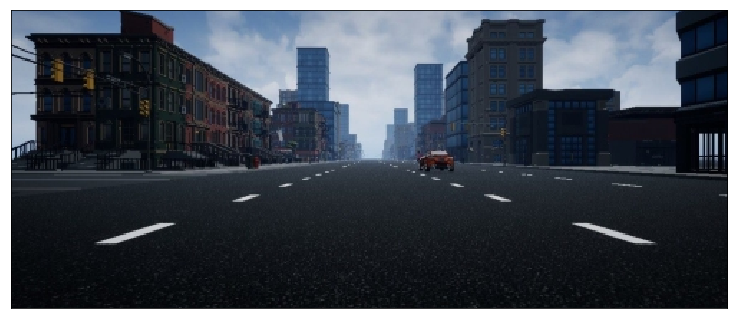

after white color selection


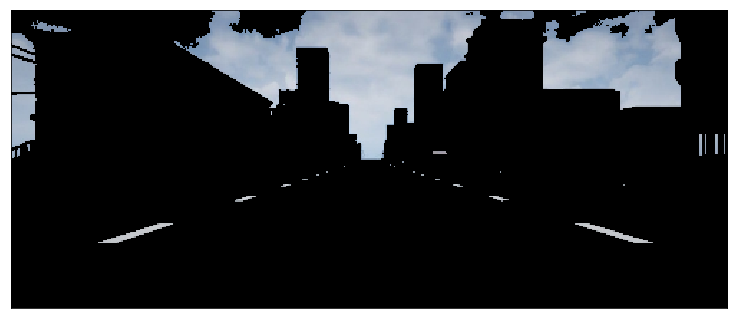

after converting to grayscale


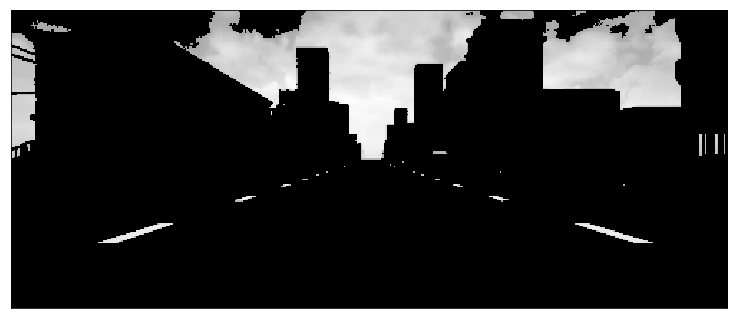

after smoothing


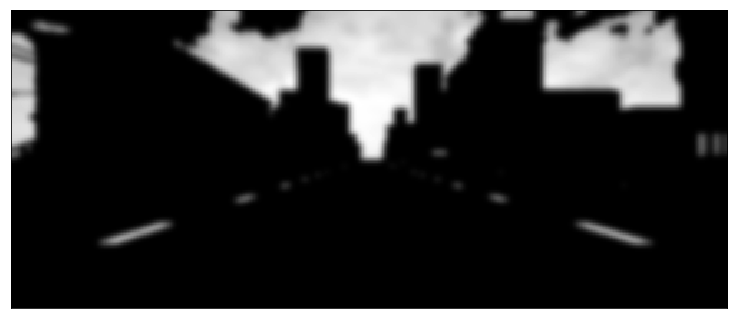

after edge detection


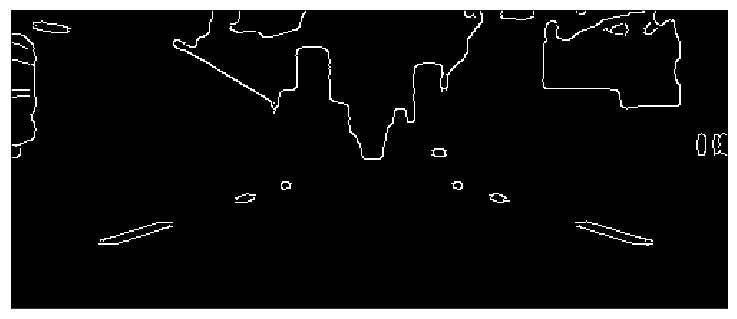

after ROI


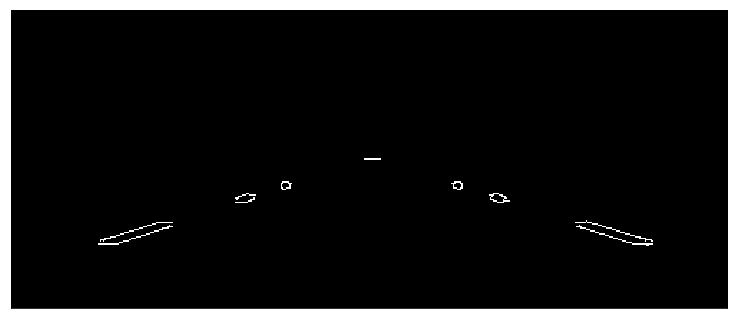

[[249]
 [104]]


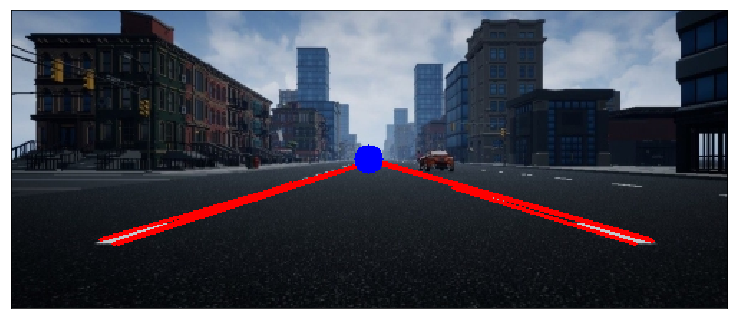

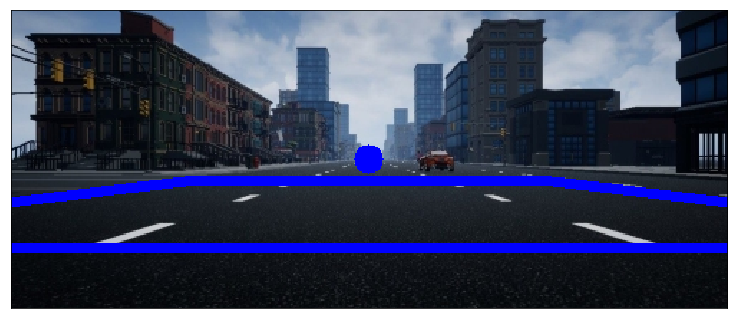

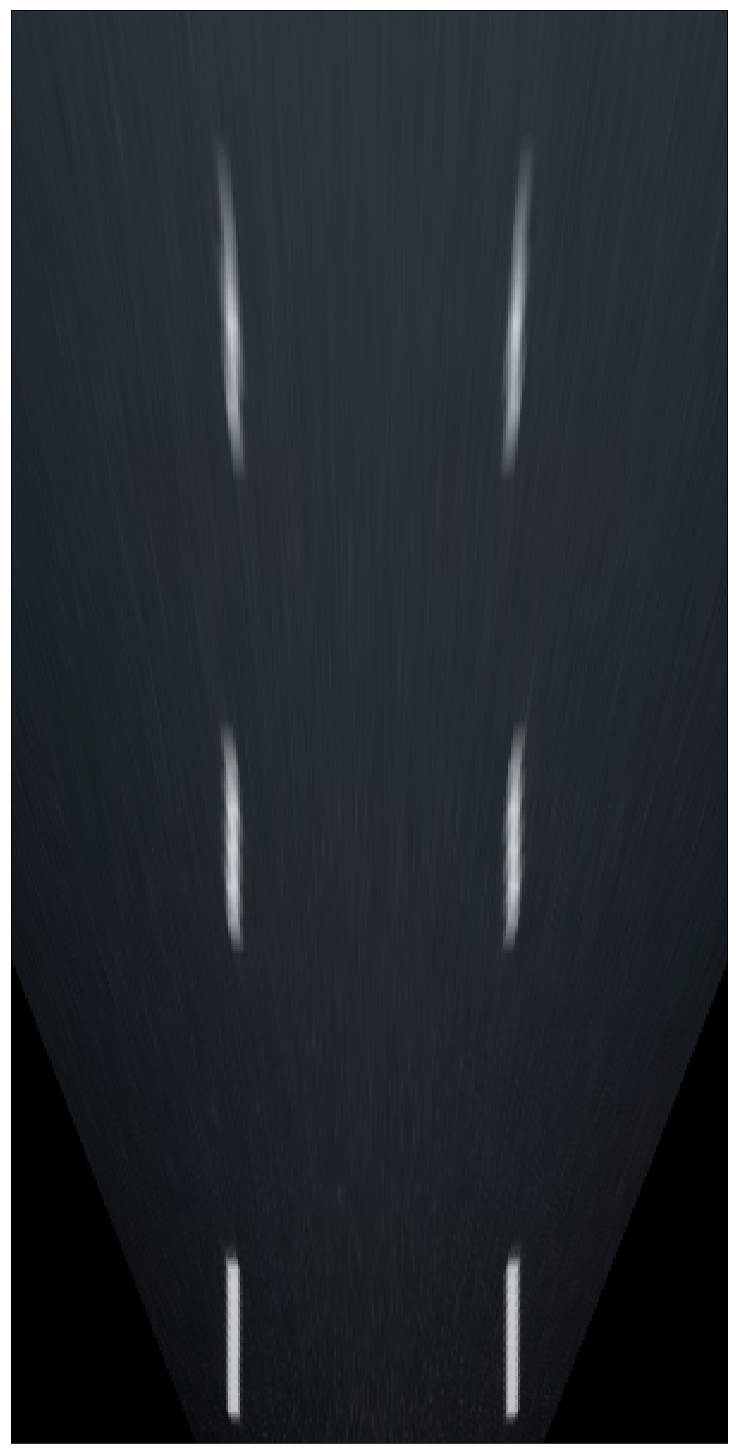

after white color selection


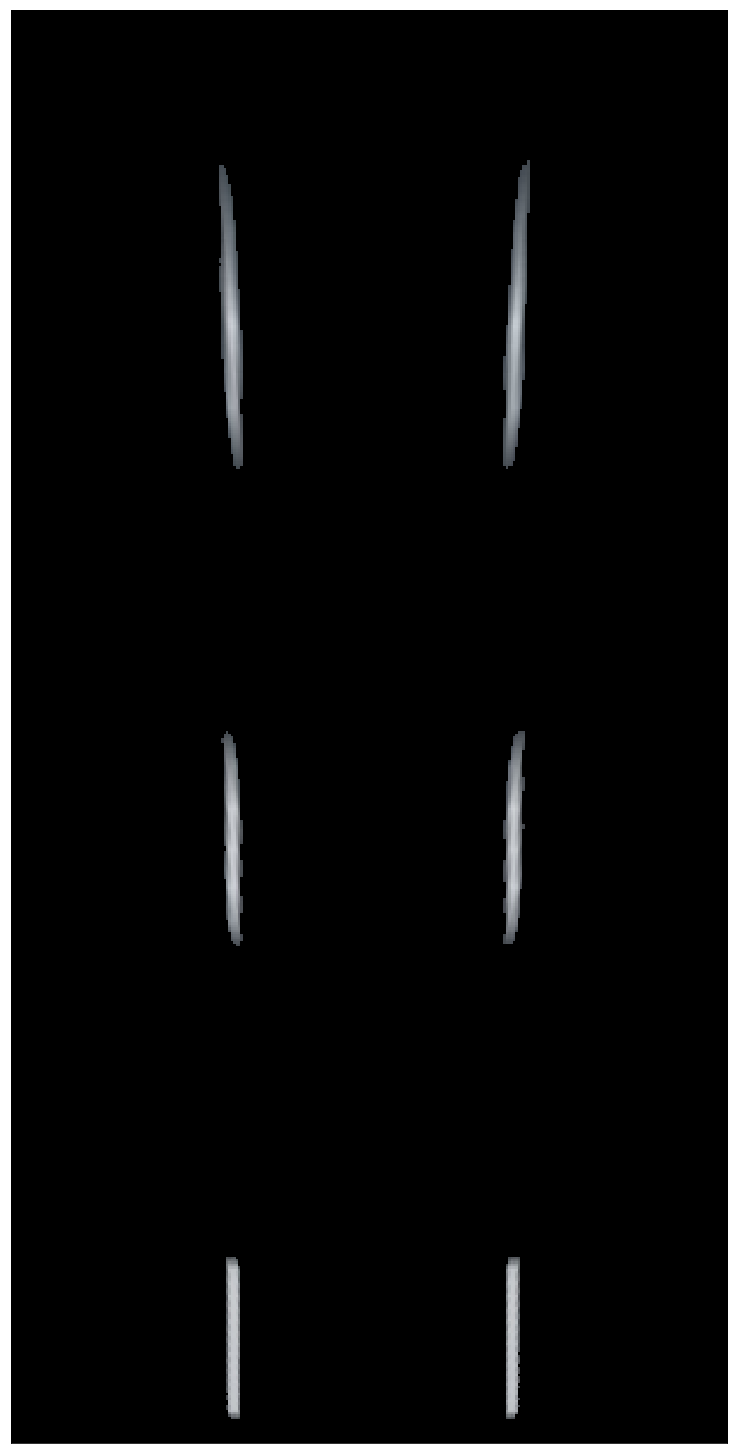

after converting to grayscale


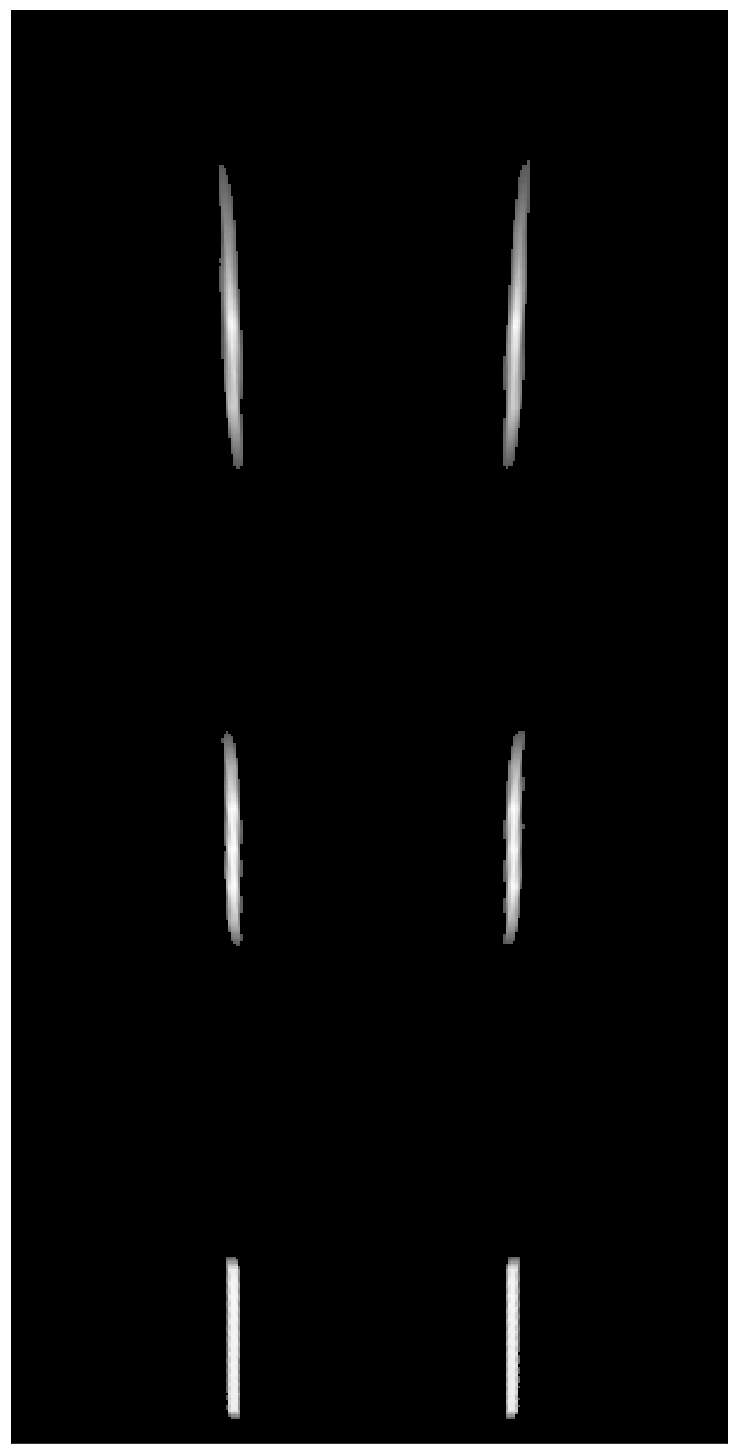

after smoothing


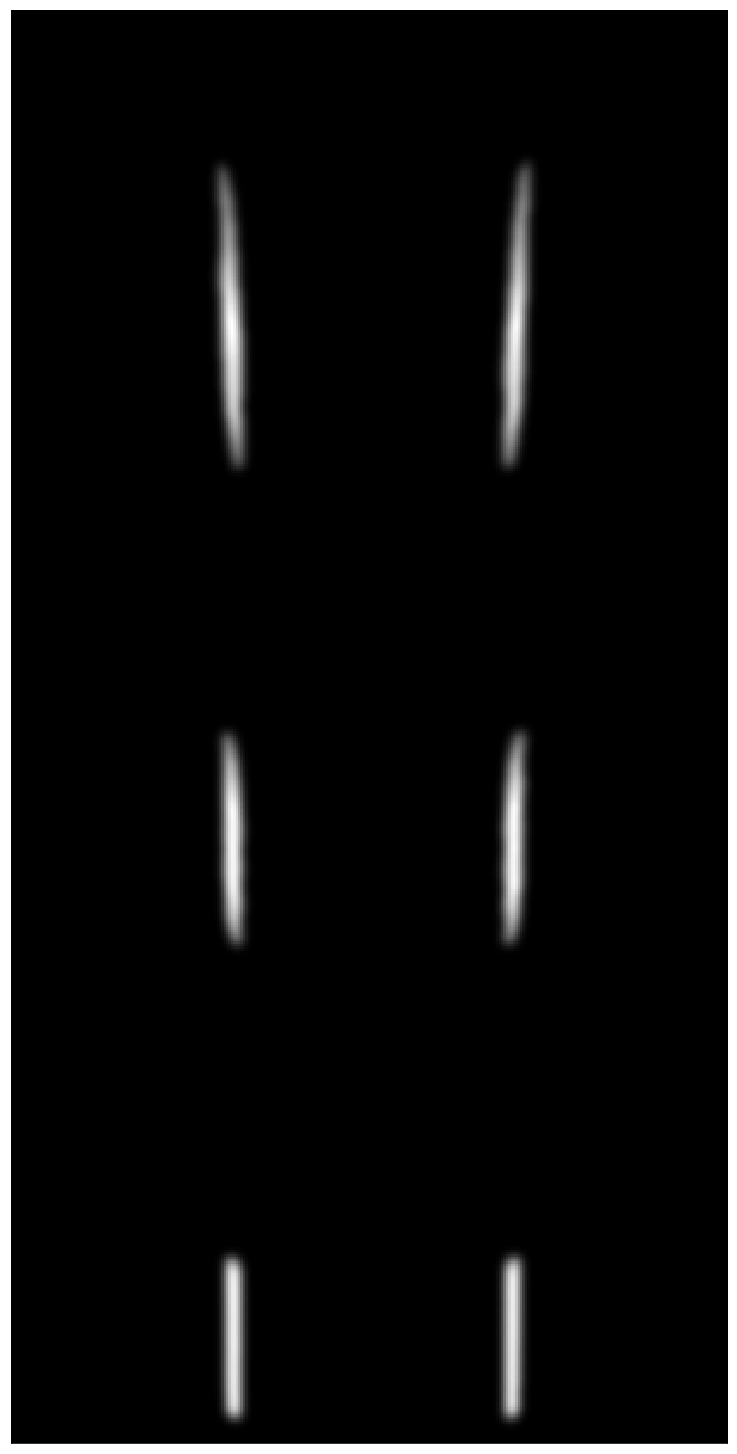

after edge detection


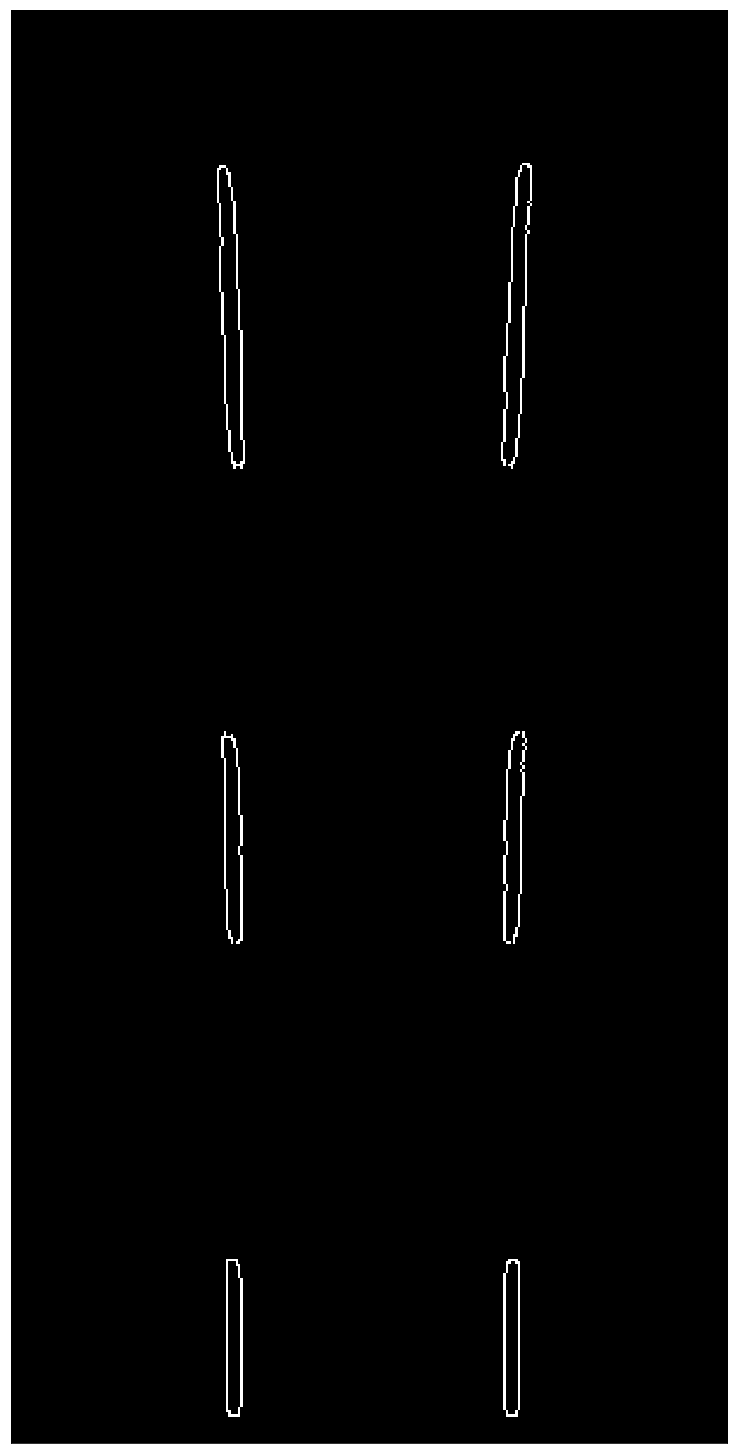

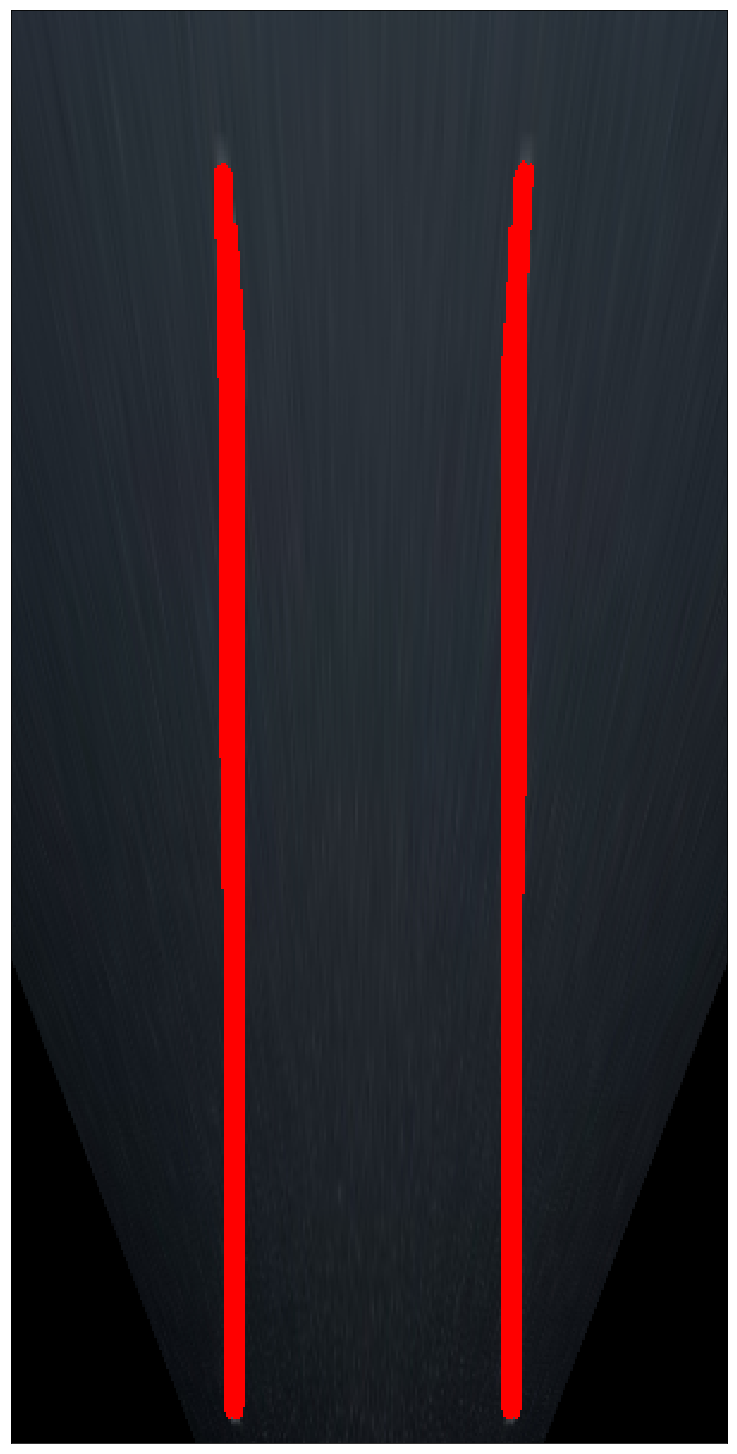

pxls/mtr: 32.534996666666665,16.893975806699917


In [9]:
img = cv2.imread('imgs/noshade500x208.JPG')
H, x_pixels_per_meter, y_pixels_per_meter = driver_perspective_transform(img, True)

In [8]:
BADAS_fns.StopBrake()